# Billiards

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/examples/particles/Billiards.ipynb)

This example simulates Billiard balls and collisions.

In [1]:
%pip install --quiet phiflow
from phi.torch.flow import *
# from phi.flow import *  # If JAX is not installed. You can use phi.torch or phi.tf as well.

Let's create a cue ball and the typical billiards triangle!

<Figure size 864x360 with 1 Axes>

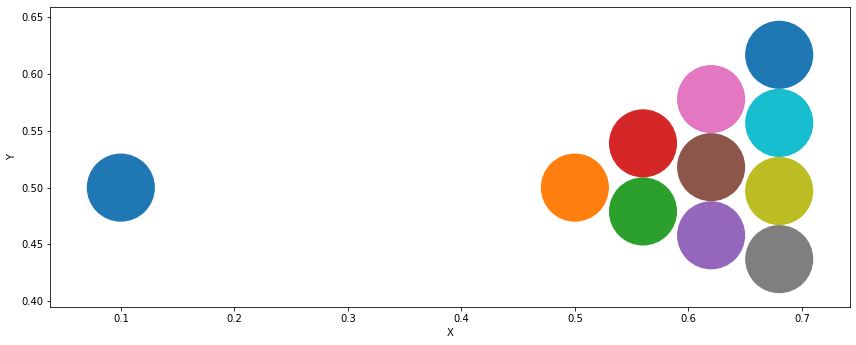

In [11]:
def create_balls(cue_pos=vec(x=.1, y=.5), billiard_layers=4, radius=.03):
    coords = [cue_pos]
    for i in range(billiard_layers):
        for j in range(i + 1):
            coords.append(vec(x=i * 2 * radius + 0.5, y=j * 2 * radius + 0.5 - i * radius * 0.7))
    return Sphere(stack(coords, instance('ball')), radius=radius)

balls = create_balls()
plot(balls, color=math.range(instance(balls)))

Next, we define the dynamics consisting of linear movement and collisions.
We store the velocities in the `values` of the field.
The impact dynamics depend on the relative distances and velocities of the balls, which we get using `math.pairwise_differences`.
Summing the neighbor contributions then amounts to summing over the dual dimension.

In [40]:
@jit_compile
def physics_step(v: PointCloud, dt: float, elasticity=0.8):
    v_next = advect.points(v, v, dt)
    x_diff = math.pairwise_differences(v_next.points)
    dist = math.vec_length(x_diff, eps=1e-4)  # eps to avoid NaN during backprop of sqrt
    rel_v = -math.pairwise_differences(v.values)
    dist_dir = -math.safe_div(x_diff, dist)
    projected_v = dist_dir.vector * rel_v.vector
    has_impact = (projected_v < 0) & (dist < 2 * v.geometry.radius)
    impulse = -(1 + elasticity) * .5 * projected_v * dist_dir
    radius_sum = v.geometry.radius + rename_dims(v.geometry.radius, instance, dual)
    impact_time = math.safe_div(dist - radius_sum, projected_v)
    x_inc_contrib = math.sum(math.where(has_impact, math.minimum(impact_time - dt, 0) * impulse, 0), dual)
    v = v.with_elements(v.geometry.shifted(x_inc_contrib))
    v += math.sum(math.where(has_impact, impulse, 0), dual)
    return advect.points(v, v, dt)

Now, let's give the cue ball a starting velocity and run the simulation!

In [47]:
v0 = math.scatter(math.zeros(balls.shape), indices=vec(ball=0), values=vec(x=3, y=0))
initial_state = Field(balls, v0, 0)
trj = iterate(physics_step, batch(t=60), initial_state, dt=0.003, substeps=2)

In [48]:
plot(trj.geometry, animate='t', color=math.range(instance(balls)))